In [3]:
import pymc3 as pm
import pandas as pd
import numpy as np
import scipy as sp
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [4]:
FILE_NEXT_TO_GO = 'next_to_go.pkl'
with open(FILE_NEXT_TO_GO, 'rb') as f:
    meeting = pickle.load(f)
print(meeting.keys())
print('distance {}'.format(meeting['raceDistance']))
horses = meeting['runners']
print(len(horses))
print(horses[0].keys())

dict_keys(['raceNumber', 'raceName', 'raceDistance', 'trackDirection', 'meeting', 'skyRacing', 'hasParimutuel', 'hasFixedOdds', 'broadcastChannel', 'broadcastChannels', 'hasForm', 'hasEarlySpeedRatings', 'allIn', 'cashOutEligibility', 'allowBundle', 'willHaveFixedOdds', 'fixedOddsOnlineBetting', 'raceStartTime', 'raceClassConditions', 'apprenticesCanClaim', 'prizeMoney', 'raceStatus', 'substitute', 'results', 'pools', 'allowMulti', 'allowParimutuelPlace', 'parimutuelPlaceStatus', 'allowFixedOddsPlace', 'numberOfPlaces', 'numberOfFixedOddsPlaces', 'runners', 'oddsUpdateTime', 'fixedOddsUpdateTime', 'tips', 'ratings', 'multiLegApproximates', 'betTypes'])
distance 1600
14
dict_keys(['runnerName', 'runnerNumber', 'fixedOdds', 'parimutuel', 'silkURL', 'trainerName', 'trainerFullName', 'barrierNumber', 'riderDriverName', 'riderDriverFullName', 'handicapWeight', 'harnessHandicap', 'blinkers', 'claimAmount', 'last5Starts', 'tcdwIndicators', 'emergency', 'penalty', 'dfsFormRating', 'techFormRat

In [6]:
engine = create_engine('sqlite:///tab.db')
conn = engine.connect()
conn
dfo = pd.read_sql_table('race', conn)
df = dfo[dfo.distance == meeting['raceDistance']]
df.describe()

,id,age,race_number,number_of_starters,draw,margin,distance,handicap,starting_position,odds,time
count,414.000000,414.000000,414.000000,414.000000,414.0,414.000000,414.0,414.000000,414.000000,401.000000,414.000000
mean,1712.618357,4.939614,4.483092,11.746377,0.0,6.422464,1600.0,57.292271,6.355072,21.387032,99.317874
std,783.049604,1.688510,2.412328,3.166245,0.0,10.266233,0.0,2.524042,3.849092,21.407531,9.667299
min,67.000000,2.000000,1.000000,4.000000,0.0,0.100000,1600.0,49.000000,1.000000,0.000000,0.000000
25%,1049.750000,4.000000,3.000000,10.000000,0.0,1.625000,1600.0,56.000000,3.000000,7.000000,97.700000
50%,1737.500000,5.000000,4.000000,11.000000,0.0,3.950000,1600.0,57.500000,6.000000,14.000000,99.400000
75%,2476.750000,6.000000,7.000000,14.000000,0.0,8.200000,1600.0,59.000000,9.000000,26.000000,101.375000
max,2734.000000,11.000000,11.000000,21.000000,0.0,104.500000,1600.0,68.500000,18.000000,101.000000,123.200000


In [7]:
df = df[['runner_name', 'handicap', 'time']]
df = df[(df.time > 0)]
df = df[(df.handicap > 0)]
df.describe()

,handicap,time
count,411.000000,411.000000
mean,57.299270,100.042822
std,2.531841,4.630094
min,49.000000,69.500000
25%,56.000000,97.700000
50%,57.500000,99.400000
75%,59.000000,101.400000
max,68.500000,123.200000


In [8]:
runners = pd.Categorical(df['runner_name'])
n_runners = len(runners.unique())
print('{} unique from {}'.format(n_runners, len(runners)))

179 unique from 411


In [11]:
time_mean = df['time'].mean()
time_std = df['time'].std()
z = (df['time'] - time_mean) / time_std
print('μ = {}'.format(time_mean))
print(time_std)
print(len(z))

μ = 100.04282238442822
4.63009411642
411


In [10]:
handicap_mean = df['handicap'].mean()
handicap_std = df['handicap'].std()
handicaps = (df['handicap'] - handicap_mean) / handicap_std
print(handicap_mean)
print(handicap_std)
print(len(handicaps))

57.299270073
2.53184102544
411


In [20]:
with pm.Model() as model:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    # priors
    μ = α + β * runners.codes
    
    σ = pm.HalfNormal('σ', sd=10)

    # likelihood
    Y_like = pm.Normal('Y_like', mu=μ, sd=σ, observed=z)

In [21]:
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 603.67:  19%|█▉        | 37845/200000 [00:03<00:16, 10087.56it/s] 
Convergence archived at 38200
Interrupted at 38,200 [19%]: Average Loss = 2,672.1
100%|██████████| 5500/5500 [00:05<00:00, 985.80it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f7b7710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12f8aa630>]], dtype=object)

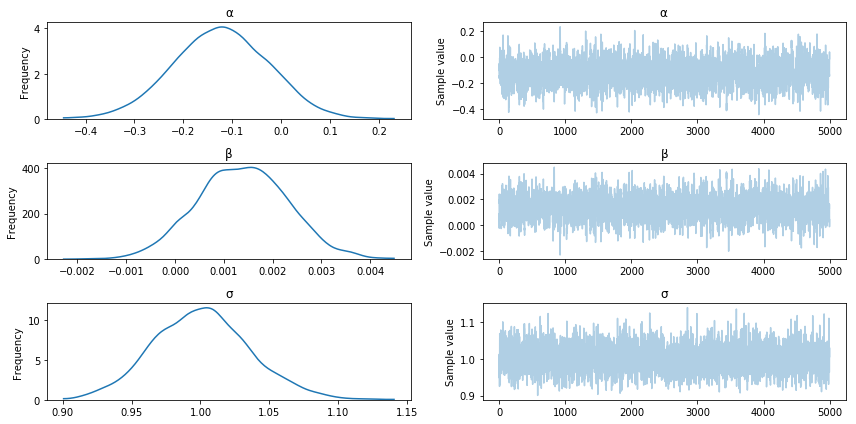

In [22]:
pm.traceplot(trace)

In [23]:
pm.summary(trace)


α:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.123           0.098            0.002            [-0.314, 0.067]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.317         -0.188         -0.124         -0.058         0.065


β:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.001            0.001            0.000            [-0.000, 0.003]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.000         0.001          0.001          0.002          0.003


σ:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f85e7b8>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x12fa1d080>]], dtype=object)

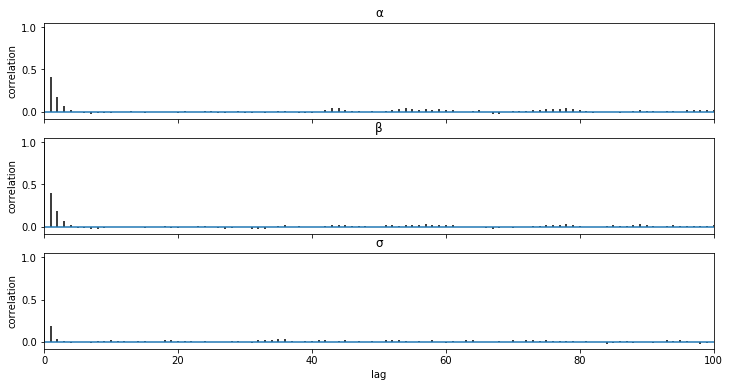

In [24]:
pm.autocorrplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12fb06e10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x12fba2710>], dtype=object)

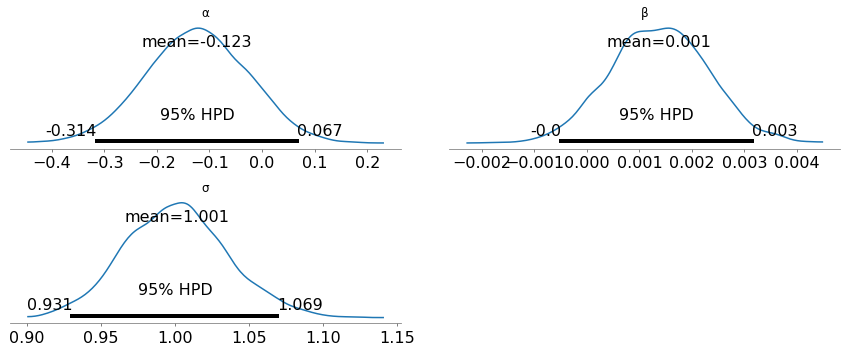

In [25]:
pm.plot_posterior(trace, kde_plot=True)

In [27]:
help(pm.sample_ppc)

Help on function sample_ppc in module pymc3.sampling:

sample_ppc(trace, samples=None, model=None, vars=None, size=None, random_seed=None, progressbar=True)
    Generate posterior predictive samples from a model given a trace.
    
    Parameters
    ----------
    trace : backend, list, or MultiTrace
        Trace generated from MCMC sampling
    samples : int
        Number of posterior predictive samples to generate. Defaults to the
        length of `trace`
    model : Model (optional if in `with` context)
        Model used to generate `trace`
    vars : iterable
        Variables for which to compute the posterior predictive samples.
        Defaults to `model.observed_RVs`.
    size : int
        The number of random draws from the distribution specified by the
        parameters in each sample of the trace.
    
    Returns
    -------
    samples : dict
        Dictionary with the variables as keys. The values corresponding
        to the posterior predictive samples.



In [26]:
for horse in horses:
    horse_name = horse['runnerName']
    print(horse_name)
    
    if horse_name not in runners:
        print('skipping...')
        continue

    print('sampling for data...')
    with model:
        post_pred = pm.sample_ppc(trace, samples=500)
    print(post_pred['Y_like'].shape)
    
    break

 16%|█▌        | 81/500 [00:00<00:00, 807.49it/s]

GHARRY WALLAH
skipping...
TOW ROPE
skipping...
DIAMONDS FOR ALL
sampling for data...


100%|██████████| 500/500 [00:00<00:00, 1894.03it/s]

(500, 411)
